# Projeto2 de Engenharia do Conhecimento

Neste projeto pretende-se selecionar os melhores modelos de classificação possiveis usando os métodos dados em aula.
O Dataset estudado é uma versão editada e aprimorada do QSAR biodegradation Data Set, e a variável a classificar é Biodegradable.
Neste projeto é usada a técnina Grid Search para definir os melhores hiper-parâmetros para cada modelo de classificação.

Começamos então por importar todas a bibliotecas necessárias para a execução do nosso notebook:

In [210]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector, f_classif 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix, classification_report

E de seguida importamos o ficheiro csv para data, usando o método read_csv do panda para criar um dataset do estilo que temos em baixo com este ficheiro:

In [211]:
data = pd.read_csv('biodegradable_a.csv', sep=',', header=None)

In [212]:
data

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,SpMax_L,J_Dz(e),nHM,F01,F04,NssssC,nCb,C,nCp,nO,...,C_026,F02_CN,nHDon,SpMax_B,Psi_i_A,nN,SM6_B,nArCOOR,nX,Biodegradable
1,3.919,2.6909,0.0,0.0,0.0,0.0,0.0,31.4,2.0,0.0,...,0.0,0.0,0.0,2.949,1.591,0.0,7.253,0.0,0.0,RB
2,4.17,2.1144,0.0,0.0,0.0,0.0,0.0,30.8,1.0,1.0,...,0.0,0.0,0.0,3.315,1.967,0.0,7.257,0.0,0.0,RB
3,3.932,3.2512,0.0,0.0,0.0,0.0,0.0,26.7,2.0,4.0,...,0.0,0.0,1.0,NaN,2.417,0.0,7.601,0.0,0.0,RB
4,3.0,2.7098,0.0,0.0,0.0,0.0,0.0,20.0,NaN,2.0,...,0.0,0.0,1.0,NaN,5.0,0.0,6.69,0.0,0.0,RB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4560,4.175650221154054,3.4546485477276168,0.0,0.0,0.0,0.0,0.0,27.3,2.0,2.0,...,0.0,0.0,0.0,3.3983819479917696,3.2410900893796684,0.0,7.406747594846807,0.0,0.0,RB
4561,3.853730569534719,2.747141834295752,0.0,NaN,0.0,0.0,0.0,33.3,0.0,0.0,...,0.0,0.0,1.0,3.4291479563760205,2.7193085779457116,0.0,7.511510650794673,0.0,0.0,RB
4562,4.2947709909647,3.471225936195339,0.0,0.0,0.0,0.0,0.0,28.42215386583151,2.0,2.0,...,0.0,0.0,0.0,3.3516663737107066,2.7294558209008986,0.0,7.699323519308668,0.0,0.0,RB
4563,4.560375722905787,3.8963903146205348,0.0,0.0,0.0,0.0,0.0,NaN,2.0,3.0,...,0.0,0.0,0.0,NaN,3.0591980135789765,0.0,7.9088019864210235,0.0,0.0,RB


## Tratamento dos Dados
Como podemos observar na tabela e também como é referido no enunciado, os dados têm valores em falta, não estão normalizados, e contêm variáveis categóricas e contínuas, portanto antes de começar a avaliar os modelos, temos que tratar os dados.

Começamos por separar a variável a classificar das restantes, atribuindo a X todo o Dataset menos a última coluna (coluna da variável a classificar Biodegradable) e menos a primeira linha (para remover o nome das colunas).
A y atribuimos apenas a última coluna do Dataset (coluna da variável a classificar Biodegradable) sem a primeira linha também para remover o nome da coluna:

In [213]:
#Separação dos dados dos nomes das colunas
X = data.iloc[1:,:-1]
y = data.iloc[1:, -1]

De seguida, usamos o SimpleImputer com a estratégia 'median' para preencher os valores em falta do Dataset:

In [214]:
#Preenche espaços vazios no dataset usando o SimpleImputer com a strategy median
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X))

Usamos o StandardScaler para normalizar os dados:

In [215]:
#Normalização dos dados usando o StandardScalers
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))

E selecionamos as colunas mais importantes. Usamos o SequentialFeatureSelector com Logistic Regression avalia as interações entre as colunas e escolhe que colunas seleciona com base no seu impacto no desempenho do modelo.
São selecionadas as 15 colunas mais importantes, 15 para não serem nem demasiadas colunas, nem demasiado poucas. Demasiadas colunas, principalmente usando o Grid Search pode causar tempos de execução muito longos, enquanto poucas podem por em causa os resultados obtidos:

#### Nota:
Pode demorar uns minutos a executar

In [216]:
selector = SequentialFeatureSelector(estimator=LogisticRegression(), n_features_to_select=15, direction='forward')
selector.fit(X, y)

selected_features = selector.transform(X)

X = pd.DataFrame(selector.fit_transform(X, y))

print(selected_features)
X

[[-1.32053051 -0.23321562 -0.07675026 ... -0.09490415 -0.3205301
  -1.77440061]
 [-0.79829278 -0.23321562 -0.07675026 ... -0.09490415 -0.3205301
  -1.13033578]
 [-1.29348234 -0.23321562 -0.07675026 ... -0.09490415 -0.3205301
  -0.3595135 ]
 ...
 [-0.5386907  -0.23321562 -0.07675026 ... -0.09490415 -0.3205301
   0.17570406]
 [ 0.01393405 -0.23321562 -0.07675026 ... -0.09490415 -0.3205301
   0.74053212]
 [-1.05816877 -0.23321562 -0.07675026 ... -0.09490415  1.22179923
  -0.02316524]]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-1.320531,-0.233216,-0.07675,-0.128692,-1.357445,-0.243517,0.391883,-0.960663,-0.110677,-0.066009,0.116323,0.573379,-0.094904,-0.320530,-1.774401
1,-0.798293,-0.233216,-0.07675,-0.128692,-0.694838,-0.243517,0.391883,-0.684685,-0.110677,-0.066009,-1.254320,-0.602971,-0.094904,-0.320530,-1.130336
2,-1.293482,-0.233216,-0.07675,-0.128692,1.292985,-0.243517,0.391883,-0.960663,-0.110677,-0.066009,-0.004804,0.733844,-0.094904,-0.320530,-0.359514
3,-3.232628,-0.233216,-0.07675,-0.128692,-0.032230,-0.243517,0.391883,-0.960663,-0.110677,-0.066009,6.886659,-0.686397,-0.094904,-0.320530,4.065006
4,-0.660971,-0.233216,-0.07675,-0.128692,1.292985,-0.243517,0.034488,-0.408707,-0.110677,-0.066009,0.033447,1.012065,-0.094904,-0.320530,-0.380069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4559,-0.786537,-0.233216,-0.07675,-0.128692,-0.032230,-0.243517,-0.014714,-0.684685,-0.110677,-0.066009,2.192375,-0.576829,-0.094904,-0.320530,1.052102
4560,-1.456332,-0.233216,-0.07675,-0.128692,-1.357445,-0.243517,0.391883,-0.960663,-0.110677,-0.066009,-0.122743,-0.575417,-0.094904,-0.320530,0.158322
4561,-0.538691,-0.233216,-0.07675,-0.128692,-0.032230,-0.243517,0.063353,-0.684685,-0.110677,-0.066009,-0.335619,0.051879,-0.094904,-0.320530,0.175704
4562,0.013934,-0.233216,-0.07675,-0.128692,0.630377,-0.243517,0.090427,0.419228,-0.110677,-0.066009,-0.245804,-0.062540,-0.094904,-0.320530,0.740532


## Escolha de Modelos

Começamos então por dividir os dados em sets de treino e testes:

In [217]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Para este projeto escolhemos 2 modelos simples dados no início do semestre, e 2 dados mais próximo do fim da matéria.
Escolhemos os modelos Logistic Regression, DecisionTree, RandomForest e Support Vector Machine (SVM). Como já foi referido no início do notebook, será usada a técnica do Grid Search para obtermos os melhores hiper-parametros de cada modelo.

### Logistic Regression
O Logistic Regression é um modelo usado frequentemente para classificação binária que tem como objetivo calcular a probabilidade que uma instância é positiva.

Por ser um Dataset grande, foi definido que max_iter = 10000 para aumentar o número máximo de iterações que o modelo pode fazer

Após definir a grid com os parametros, é possível usar o GridSearch para então calcular os melhores e de seguida fazemos Cross Validation para calcular a Accuracy:

In [218]:
lr = LogisticRegression(max_iter = 10000)
lr_param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1.0, 10.0],
    'solver': ['liblinear', 'saga']
}

lr_grid_search = GridSearchCV(lr, lr_param_grid, cv = 5, scoring='accuracy')
lr_grid_search.fit(X_train, y_train)
print("Logistic Regression Best Params: ", lr_grid_search.best_params_)
lr_scores = cross_val_score(lr_grid_search.best_estimator_, X_train, y_train, cv=5)
print("Logistic Regression Estimated Accuracy: %7.4f" % (lr_scores.mean()))

Logistic Regression Best Params:  {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Estimated Accuracy:  0.9515


Podemos verificar que C = 10.0, penalty = 'l1' e solver = 'saga' são os melhores hiper-parametros para este modelo, segundo a técnica do GridSearch.

### Decision Tree
As Decision Trees são modelos que envolvem a divisão recursiva dos dados em subconjuntos com base nos atributos que possuem maior poder de discriminação. Para fazer as divisões, as Decision Trees utilizam medidas de impureza, como o índice de Gini ou a entropia, para avaliar a pureza dos subconjuntos.

Após definir a grid com os parametros, usamos o GridSearch para calcular os melhores parametros e de seguida fazemos Cross Validation para calcular a Accuracy:

In [219]:
dt = DecisionTreeClassifier(min_samples_leaf = 5)
dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3]
}

dt_grid_search = GridSearchCV(dt, dt_param_grid, cv=5, scoring='accuracy')
dt_grid_search.fit(X_train, y_train)
print("DecisionTree Best Params: ", dt_grid_search.best_params_)
dt_scores = cross_val_score(dt_grid_search.best_estimator_, X_train, y_train, cv=5)
print("DecisionTree Estimated Accuracy: %7.4f" % (dt_scores.mean()))

DecisionTree Best Params:  {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
DecisionTree Estimated Accuracy:  0.9477


### Random Forest
Este é o modelo de "Bagging" mais comum. Versátil para tratar de diferentes problemas de aprendizagem supervisionados. Usa DecisionTrees como modelo fraco pois são rápidos a 'aprender' e flexiveis o suficiente para acomodar várias subdivisões dos dados.

Após definir a grid com os parametros , usamos o Grid Search para calcular os melhores hiper-parametros e de seguida fazemos Cross Validation para calcular a Accuracy:

#### Nota:
Pode demorar uns minutos a executar

In [220]:
rf = RandomForestClassifier()
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2']
}

rf_grid_search = GridSearchCV(rf, rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(X_train, y_train)
print("Random Forest Best Params: ", rf_grid_search.best_params_)
rf_scores = cross_val_score(rf_grid_search.best_estimator_, X_train, y_train, cv=5)
print("Random Forest Estimated Accuracy: %7.4f" % (rf_scores.mean()))

Random Forest Best Params:  {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Random Forest Estimated Accuracy:  0.9628


### SVM
O Support Vector Machine (SVM) é um modelo que pode ser usado tanto para classificação e regressão e neste caso vamos usar o Support Vector Classifier (SVC). Este procura um plano ótimo que maximize a margem entre as classes, utilizando o Kernel Trick para lidar com dados linearmente inseparáveis. É também conhecido pela sua eficácia em problemas de classificação binários e a sua capacidade de lidar com dados de grandes dimensões.

Após definir a grid com os parâmetros , usamos o GridSearch para calcular os melhores hiper-parametros e de seguida fazemos Cross Validation para calcular a Accuracy:

#### Nota:
Pode demorar uns minutos a executar

In [221]:
svm = SVC()
svm_param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto']
}
svm_grid_search = GridSearchCV(svm, svm_param_grid, cv=5, scoring='accuracy')
svm_grid_search.fit(X_train, y_train)
print("SVM Best Params: ", svm_grid_search.best_params_)
svm_scores = cross_val_score(svm_grid_search.best_estimator_, X_train, y_train, cv=5)
print("SVM Estimated Accuracy: %7.4f" % (svm_scores.mean()))


SVM Best Params:  {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
SVM Estimated Accuracy:  0.9534


### Primeira Análise
Apenas olhando para a estimativa da Accuracy usando Cross Validation com os dados de treino, todos têm classificações satisfatórias, mas o Random Forest e o SVC são os melhores candidatos.
Embora se observe uma Accuracy ligeiramente superior no RandomForest, estes dados são uma estimativa usando os dados de treino do Dataset e não são o suficiente para tirar uma conclusão, portanto vamos fazer uma avaliação aos modelos com 'predictions' e os dados de teste usando diferentes métricas, como o F1Score, Matthews Correlation Coefficient, Precision e Recall.
Foram feitas duas avaliações diferentes, para Biodegradable = 'RB' e para Biodegradable = 'NRB':

## Avaliação dos Modelos (RB)

### Avaliação Logistic Regression
Começamos por avaliar o modelo Logistic Regression:

In [222]:
lr_grid_search.best_estimator_.fit(X_train, y_train)
lr_pred = lr_grid_search.best_estimator_.predict(X_test)
print("Logistic Regression Metrics:")
print("Accuracy: %7.4f" % accuracy_score(y_test, lr_pred))
print("Precision: %7.4f" % precision_score(y_test, lr_pred, pos_label='RB'))
print("Recall: %7.4f" % recall_score(y_test, lr_pred, pos_label='RB'))
print("Matthews correlation coefficient: %7.4f" % matthews_corrcoef(y_test, lr_pred))
print("F1-score: %7.4f" % f1_score(y_test, lr_pred, pos_label='RB'))

Logistic Regression Metrics:
Accuracy:  0.9441
Precision:  0.9561
Recall:  0.9775
Matthews correlation coefficient:  0.7958
F1-score:  0.9667


Conseguimos ver numa Confusion Matrix o desempenho do modelo:

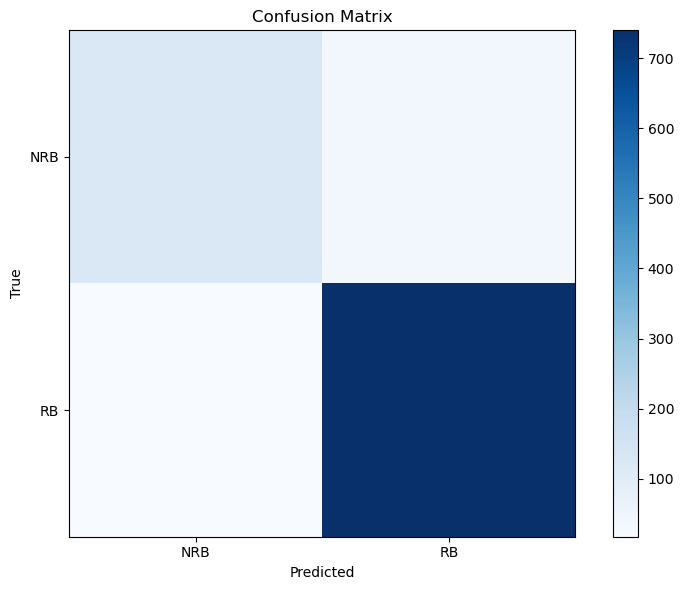

In [223]:
cm = confusion_matrix(y_test, lr_pred)

cr = classification_report(y_test, lr_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, ['NRB', 'RB'])
plt.yticks(tick_marks, ['NRB', 'RB'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

### Avaliação Decision Tree

In [224]:
dt_grid_search.best_estimator_.fit(X_train, y_train)
dt_pred = dt_grid_search.best_estimator_.predict(X_test)
print("Decision Tree Metrics:")
print("Accuracy: %7.4f" % accuracy_score(y_test, dt_pred))
print("Precision: %7.4f" % precision_score(y_test, dt_pred, pos_label='RB'))
print("Recall: %7.4f" % recall_score(y_test, dt_pred, pos_label='RB'))
print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, dt_pred))
print("F1-score: %7.4f" % f1_score(y_test, dt_pred, pos_label='RB'))

Decision Tree Metrics:
Accuracy:  0.9419
Precision:  0.9718
Recall:  0.9577
The Matthews correlation coefficient is:  0.8014
F1-score:  0.9647


Conseguimos ver numa Confusion Matrix o desempenho do modelo:

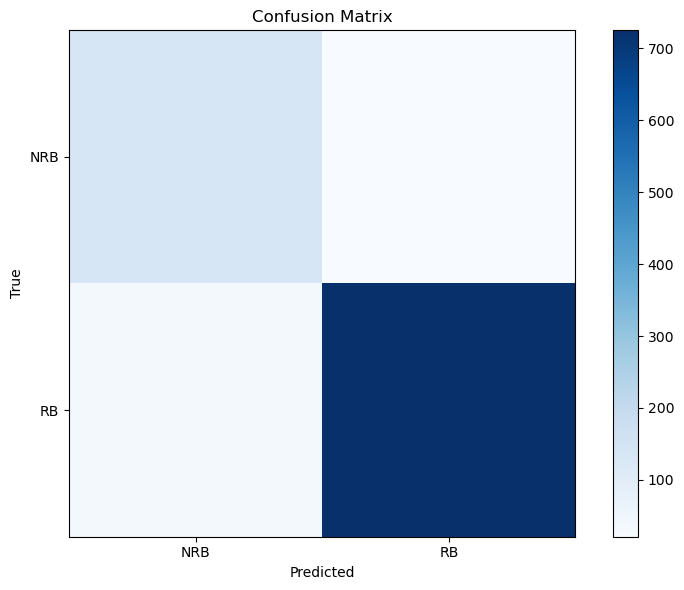

In [225]:
cm = confusion_matrix(y_test, dt_pred)

cr = classification_report(y_test, dt_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, ['NRB', 'RB'])
plt.yticks(tick_marks, ['NRB', 'RB'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

### Avaliação Random Forest

In [226]:
rf_grid_search.best_estimator_.fit(X_train, y_train)
rf_pred = rf_grid_search.best_estimator_.predict(X_test)
print("Random Forest Metrics:")
print("Accuracy: %7.4f" % accuracy_score(y_test, rf_pred))
print("Precision: %7.4f" % precision_score(y_test, rf_pred, pos_label='RB'))
print("Recall: %7.4f" % recall_score(y_test, rf_pred, pos_label='RB'))
print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, rf_pred))
print("F1-score: %7.4f" % f1_score(y_test, rf_pred, pos_label='RB'))

Random Forest Metrics:
Accuracy:  0.9595
Precision:  0.9749
Recall:  0.9762
The Matthews correlation coefficient is:  0.8566
F1-score:  0.9756


Conseguimos ver numa Confusion Matrix o desempenho do modelo:

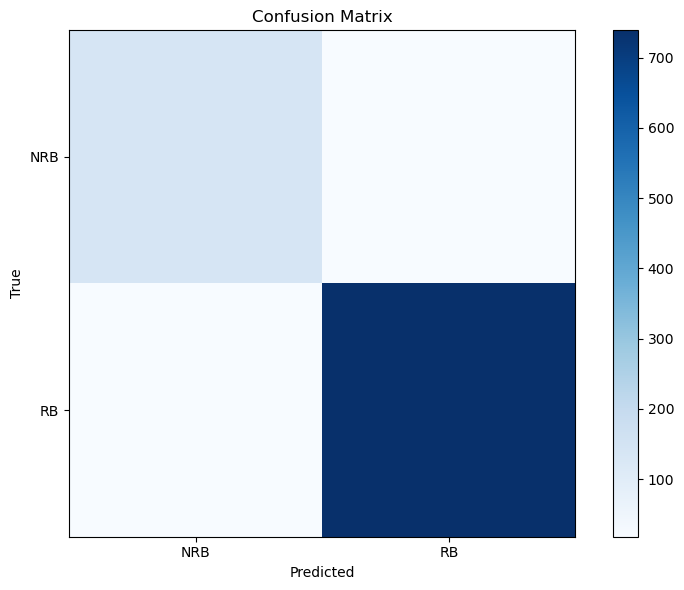

In [227]:
cm = confusion_matrix(y_test, rf_pred)

cr = classification_report(y_test, rf_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, ['NRB', 'RB'])
plt.yticks(tick_marks, ['NRB', 'RB'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

### Avaliação SVM

In [228]:
svm_grid_search.best_estimator_.fit(X_train, y_train)
svm_pred = svm_grid_search.best_estimator_.predict(X_test)
print("SVM Metrics:")
print("Accuracy: %7.4f" % accuracy_score(y_test, svm_pred))
print("Precision: %7.4f" % precision_score(y_test, svm_pred, pos_label='RB'))
print("Recall: %7.4f" % recall_score(y_test, svm_pred, pos_label='RB'))
print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, svm_pred))
print("F1-score: %7.4f" % f1_score(y_test, svm_pred, pos_label='RB'))

SVM Metrics:
Accuracy:  0.9540
Precision:  0.9613
Recall:  0.9841
The Matthews correlation coefficient is:  0.8321
F1-score:  0.9726


Conseguimos ver numa Confusion Matrix o desempenho do modelo:

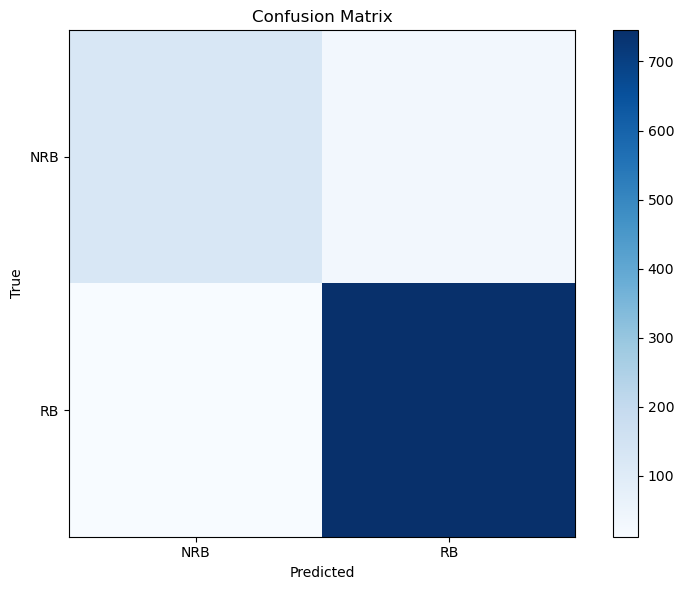

In [229]:
cm = confusion_matrix(y_test, svm_pred)

cr = classification_report(y_test, svm_pred)

plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, ['NRB', 'RB'])
plt.yticks(tick_marks, ['NRB', 'RB'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

## Avaliação dos Modelos (NRB)
Os gráficos da Confusion Matrix não serão exibidos pois são os mesmos.

### Avaliação Logistic Regression

In [230]:
lr_grid_search.best_estimator_.fit(X_train, y_train)
lr_pred = lr_grid_search.best_estimator_.predict(X_test)
print("Logistic Regression Metrics:")
print("Accuracy: %7.4f" % accuracy_score(y_test, lr_pred))
print("Precision: %7.4f" % precision_score(y_test, lr_pred, pos_label='NRB'))
print("Recall: %7.4f" % recall_score(y_test, lr_pred, pos_label='NRB'))
print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, lr_pred))
print("F1-score: %7.4f" % f1_score(y_test, lr_pred, pos_label='NRB'))

Logistic Regression Metrics:
Accuracy:  0.9441
Precision:  0.8777
Recall:  0.7821
The Matthews correlation coefficient is:  0.7958
F1-score:  0.8271


### Avaliação Decision Tree

In [231]:
dt_grid_search.best_estimator_.fit(X_train, y_train)
dt_pred = dt_grid_search.best_estimator_.predict(X_test)
print("Decision Tree Metrics:")
print("Accuracy: %7.4f" % accuracy_score(y_test, dt_pred))
print("Precision: %7.4f" % precision_score(y_test, dt_pred, pos_label='NRB'))
print("Recall: %7.4f" % recall_score(y_test, dt_pred, pos_label='NRB'))
print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, dt_pred))
print("F1-score: %7.4f" % f1_score(y_test, dt_pred, pos_label='NRB'))

Decision Tree Metrics:
Accuracy:  0.9419
Precision:  0.8047
Recall:  0.8718
The Matthews correlation coefficient is:  0.8026
F1-score:  0.8369


### Avaliação Random Forest

In [232]:
rf_grid_search.best_estimator_.fit(X_train, y_train)
rf_pred = rf_grid_search.best_estimator_.predict(X_test)
print("Random Forest Metrics:")
print("Accuracy: %7.4f" % accuracy_score(y_test, rf_pred))
print("Precision: %7.4f" % precision_score(y_test, rf_pred, pos_label='NRB'))
print("Recall: %7.4f" % recall_score(y_test, rf_pred, pos_label='NRB'))
print("The Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, rf_pred))
print("F1-score: %7.4f" % f1_score(y_test, rf_pred, pos_label='NRB'))

Random Forest Metrics:
Accuracy:  0.9617
Precision:  0.8954
Recall:  0.8782
The Matthews correlation coefficient is:  0.8637
F1-score:  0.8867


### Avaliação SVM

In [233]:
svm_grid_search.best_estimator_.fit(X_train, y_train)
svm_pred = svm_grid_search.best_estimator_.predict(X_test)
print("SVM Metrics:")
print("Accuracy: %7.4f" % accuracy_score(y_test, svm_pred))
print("Precision: %7.4f" % precision_score(y_test, svm_pred, pos_label='NRB'))
print("Recall: %7.4f" % recall_score(y_test, svm_pred, pos_label='NRB'))
print("Matthews correlation coefficient: %7.4f" % matthews_corrcoef(y_test, svm_pred))
print("F1-score: %7.4f" % f1_score(y_test, svm_pred, pos_label='NRB'))

SVM Metrics:
Accuracy:  0.9540
Precision:  0.9130
Recall:  0.8077
Matthews correlation coefficient:  0.8321
F1-score:  0.8571


## Conclusão:

Na avaliação podemos verificar que os modelos que melhor pontuam em Accuracy são o Random Forest e o SVM as restantes métricas bastante semelhantes entre si. 

Para uma melhor comparação entre os dois, podemos analisar as suas métricas lado a lado:

Para Biodegradable = 'RB'

In [236]:
print("Random Forest Accuracy: %7.4f" % accuracy_score(y_test, rf_pred))
print("SVM Accuracy: %7.4f" % accuracy_score(y_test, svm_pred))
print("Random Forest Precision: %7.4f" % precision_score(y_test, rf_pred, pos_label='RB'))
print("SVM Precision: %7.4f" % precision_score(y_test, svm_pred, pos_label='RB'))
print("Random Forest Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, rf_pred))
print("SVM Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, svm_pred))
print("Random Forest Recall: %7.4f" % recall_score(y_test, rf_pred, pos_label='RB'))
print("SVM Recall: %7.4f" % recall_score(y_test, svm_pred, pos_label='RB'))
print("Random Forest F1-score: %7.4f" % f1_score(y_test, rf_pred, pos_label='RB'))
print("SVM F1-score: %7.4f" % f1_score(y_test, svm_pred, pos_label='RB'))

Random Forest Accuracy:  0.9617
SVM Accuracy:  0.9540
Random Forest Precision:  0.9750
SVM Precision:  0.9613
Random Forest Matthews correlation coefficient is:  0.8637
SVM Matthews correlation coefficient is:  0.8321
Random Forest Recall:  0.9789
SVM Recall:  0.9841
Random Forest F1-score:  0.9769
SVM F1-score:  0.9726


Para Biodegradable = 'NRB'

In [235]:
print("Random Forest Accuracy: %7.4f" % accuracy_score(y_test, rf_pred))
print("SVM Accuracy: %7.4f" % accuracy_score(y_test, svm_pred))
print("Random Forest Precision: %7.4f" % precision_score(y_test, rf_pred, pos_label='NRB'))
print("SVM Precision: %7.4f" % precision_score(y_test, svm_pred, pos_label='NRB'))
print("Random Forest Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, rf_pred))
print("SVM Matthews correlation coefficient is: %7.4f" % matthews_corrcoef(y_test, svm_pred))
print("Random Forest Recall: %7.4f" % recall_score(y_test, rf_pred, pos_label='NRB'))
print("SVM Recall: %7.4f" % recall_score(y_test, svm_pred, pos_label='NRB'))
print("Random Forest F1-score: %7.4f" % f1_score(y_test, rf_pred, pos_label='NRB'))
print("SVM F1-score: %7.4f" % f1_score(y_test, svm_pred, pos_label='NRB'))

Random Forest Accuracy:  0.9617
SVM Accuracy:  0.9540
Random Forest Precision:  0.8954
SVM Precision:  0.9130
Random Forest Matthews correlation coefficient is:  0.8637
SVM Matthews correlation coefficient is:  0.8321
Random Forest Recall:  0.8782
SVM Recall:  0.8077
Random Forest F1-score:  0.8867
SVM F1-score:  0.8571


As métricas que variam consoante o valor de Biodegradable colocam o Random Forest e o SVM em empate. Podemos concluir que ambos são modelos robustos e eficientes para problemas de classificação, pelos valores das métricas usadas e também se verifica visualmente nas Confusion Matrix que ambos atingem bons resultados. Pela Accuracy e Matthews Correlation Coefficient, o modelo Random Forest costuma atingir melhores resultados. Sendo a Accuracy a métrica escolhida para influenciar o aperfeiçoamento dos hiper-parâmetros dos modelos, e MCC que avalia a qualidade das classificações binárias, o Random Forest é o melhor modelo de classificação produzido no projeto para o QSAR biodegradation Data Set.